### Import and Load Data

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import math
from matplotlib import gridspec
from random import sample
from random import shuffle

# !pip install -U -q h2o
import h2o
from h2o.automl import H2OAutoML

np.random.seed(0)

In [7]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...


CalledProcessError: Command '['/usr/bin/java', '-version']' returned non-zero exit status 1.

In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
#from sklearn.grid_search import GridSearchCV
#from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import utils
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.linear_model import SGDRegressor 
from sklearn.linear_model import Ridge

In [23]:
# !pip install --upgrade pip

    100% |████████████████████████████████| 1.5MB 2.8MB/s eta 0:00:01
distributed 1.21.8 requires msgpack, which is not installed.
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1


In [3]:
input_train_df = pd.read_csv('training.csv')
input_test_df = pd.read_csv('test.csv')
print("train shape: {}".format(input_train_df.shape))
print("test shape: {}".format(input_test_df.shape))

# Convert Image from string to np array of floats between 0 and 1
input_train_df.Image = input_train_df.Image.apply(lambda x: np.array(object=x.split(' '), 
                                                         dtype=float)) / 255
input_test_df.Image = input_test_df.Image.apply(lambda x: np.array(object=x.split(' '), 
                                                       dtype=float)) / 255

train shape: (7049, 31)
test shape: (1783, 2)


### Split into training and development datasets

In [4]:
from sklearn.model_selection import train_test_split
#Splitting the data into a 75/25 training and dev split
#Using random state 0 for reproducibility
train, dev = train_test_split(input_train_df, test_size=0.25, random_state = 0)
train = train.reset_index()
train.drop(columns='index', inplace=True)
dev = dev.reset_index()
dev.drop(columns='index', inplace=True)


# get the raw data for the train images and the dev images
train_images = np.concatenate(np.array(train.Image.values)).ravel()\
  .reshape(train.shape[0],9216)
dev_images = np.concatenate(dev['Image'].values).ravel()\
  .reshape(dev.shape[0],9216)

# test images
test_images = np.concatenate(np.array(input_test_df.Image.values)).ravel()\
  .reshape(input_test_df.shape[0],9216)

## EDA

## Create helper (printing) functions and print a few examples of missing data
* Are these images bad / not usable?
* Are the labels missing for good reasons?
* Are the labels missing for unknown reasons and data is good?

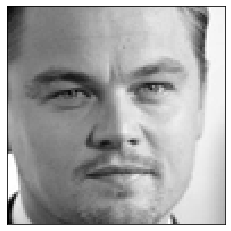

In [5]:
def plot_example(image_array, index):
    ax = plt.subplot(1,1,1)
    ax.imshow(image_array[index].reshape(96,96),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plot_example(train_images, 1800)

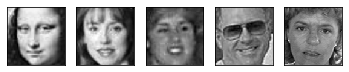

In [6]:
def plot_examples(num_examples, image_array):
    for i in range(num_examples):
        ax = plt.subplot(1,num_examples,i+1)
        ax.imshow(image_array[i].reshape(96,96),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plot_examples(5,train_images)

In [7]:
def plot_index_list(image_array, print_list):
  '''
  print_list is list of indicies in train_array to print
  '''
  
  # only want to print first 10 if long list
  list_len = min(len(print_list),10)

  plt.figure(figsize=(10,10))
  for i, print_index in enumerate(print_list):
    if i >= 10: break
    plt.subplot(1, list_len, i+1)\
      .imshow(image_array[print_index].reshape(96,96),cmap='gray')
    plt.axis('off')
    
# plot_index_list(train_images, [1866, 2137, 1687])

In [8]:
print(np.unique([np.sum(pd.isnull(feature)) for feature in np.array(input_train_df.values)[:,0:30]], return_counts=True))

(array([ 0,  2,  4,  6,  8, 10, 12, 14, 20, 22, 24]), array([2140,   87,   28,    9,    8,    3,    5,    2,    2, 4755,   10]))


### Where do features tend to be on image?
* Does any stand out as obviously bad?

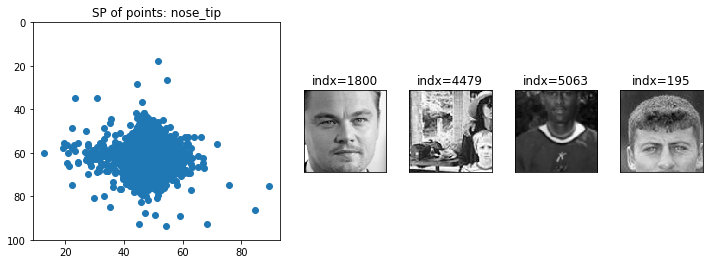

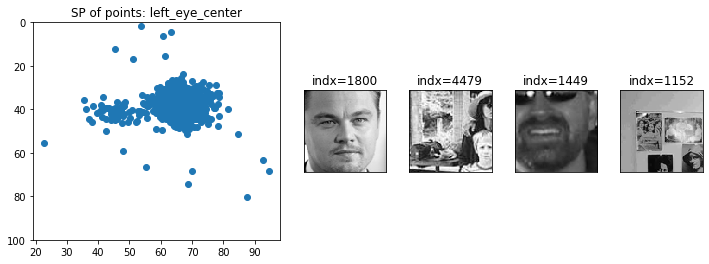

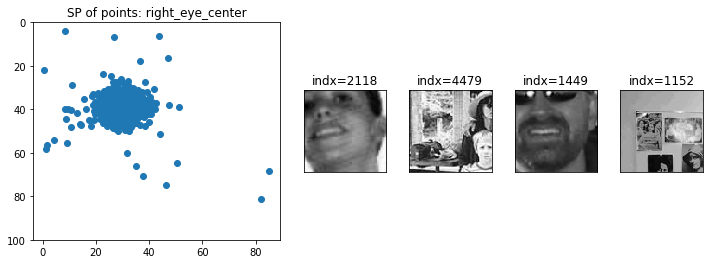

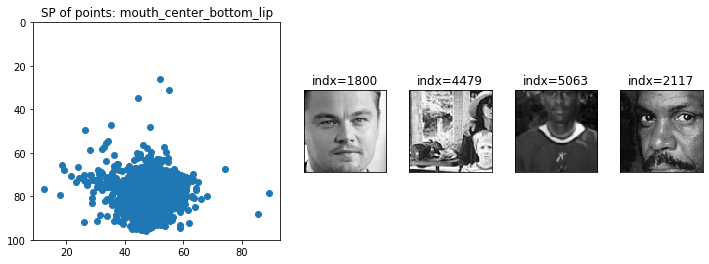

In [9]:
xy_feature_names = [
    'nose_tip',
    'left_eye_center',
    'right_eye_center',
    'mouth_center_bottom_lip'
]

for feature in xy_feature_names:
    
    x = train[feature+'_x'].values
    y = train[feature+'_y'].values

    min_x_index = np.nanargmin(train[feature+'_x'].values)
    max_x_index = np.nanargmax(train[feature+'_x'].values)
    min_y_index = np.nanargmin(train[feature+'_y'].values)
    max_y_index = np.nanargmax(train[feature+'_y'].values)

    figs_to_show = [
        min_x_index,
        max_x_index,
        min_y_index,
        max_y_index
        ]

    fig = plt.figure(figsize=(12, 4)) 
    gs = gridspec.GridSpec(1, 5, width_ratios=[3, 1, 1, 1, 1]) 
    ax0 = plt.subplot(gs[0])
    ax0.scatter(x, y)
    ax0.set_ylim((100, 0));
    ax0.set_title('SP of points: {}'.format(feature))

    for i, fig in enumerate(figs_to_show):
        
        ax = plt.subplot(gs[i+1])
        ax.imshow(train_images[fig].reshape(96,96),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title("indx={}".format(fig))

In [10]:
# bad labels -- known poor labels in multiple areas
bad_labels_indexes = [
    1800,   
    
]

# bad images -- very dark, image off screen or extremely noisy, no image
bad_image_indexes = [
    4479,
    1152,
]

### Print some missing Left Eye Images

Left Eye Center missing


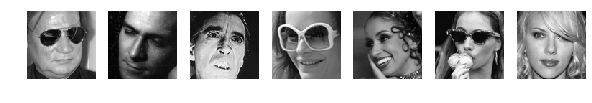

In [11]:
print('Left Eye Center missing')
feature_x = 'left_eye_center_x'
feature_y = 'left_eye_center_y'

# get indices of missing data -- print random sample
missing_list = train[train[feature_x].isnull() == True].index.tolist()
shuffle(missing_list)

plot_index_list(train_images, missing_list)

## Print some missing mouth images

Feature: nose_tip, # elements missing: 0
Feature: left_eye_center, # elements missing: 7
Feature: right_eye_center, # elements missing: 9
Feature: mouth_center_bottom_lip, # elements missing: 25


<Figure size 720x720 with 0 Axes>

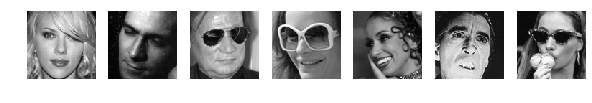

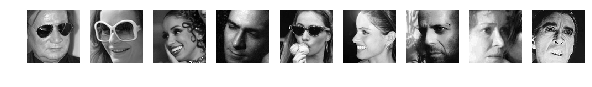

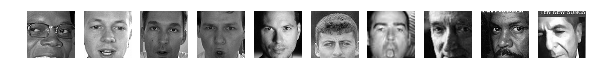

In [12]:
xy_feature_names = [
    'nose_tip',
    'left_eye_center',
    'right_eye_center',
    'mouth_center_bottom_lip'
]

for feature in xy_feature_names:
  feature_x = feature+"_x"
  feature_y = feature+"_y"

  # get indices of missing data -- print random sample
  missing_list = train[train[feature_x].isnull() == True].index.tolist()
  shuffle(missing_list)
  print('Feature: {}, # elements missing: {}'.format(feature, len(missing_list)))


  plot_index_list(train_images, missing_list)

Observations: 
* Mouth Images: Frequenty the mouth is actually missing from the picture. This would indicate that the proper treatment would be to omit it from being considered
* Eye images: generally missing for good reasons (glasses blocking, or hair blocking, or tilted such that getting a good read would be difficult)
<p>

We should remove these images for features that can't be properly detected (instead of doing the fill forward)

### Check for Missing Data

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5286 entries, 0 to 5285
Data columns (total 31 columns):
left_eye_center_x            5279 non-null float64
left_eye_center_y            5279 non-null float64
right_eye_center_x           5277 non-null float64
right_eye_center_y           5277 non-null float64
left_eye_inner_corner_x      1702 non-null float64
left_eye_inner_corner_y      1702 non-null float64
left_eye_outer_corner_x      1699 non-null float64
left_eye_outer_corner_y      1699 non-null float64
right_eye_inner_corner_x     1700 non-null float64
right_eye_inner_corner_y     1700 non-null float64
right_eye_outer_corner_x     1698 non-null float64
right_eye_outer_corner_y     1698 non-null float64
left_eyebrow_inner_end_x     1701 non-null float64
left_eyebrow_inner_end_y     1701 non-null float64
left_eyebrow_outer_end_x     1668 non-null float64
left_eyebrow_outer_end_y     1668 non-null float64
right_eyebrow_inner_end_x    1701 non-null float64
right_eyebrow_inner_end_y 

The eye centers, nose tip, and mouth center bottom are relatively well populated. Some of the other points are much less well populated.

## Forward Fill Missing Data

Since the data has multiple columns of missing information we are going to impute them using the forward fill method. Other methods: fill with median or mean. These may be things we would want to explore in the future.

Additionally, another possible approach could be to use some of the known data on the images to infer where the other features are. For example, if mouth center bottom lip is known, we could use this to infer the right/left corner of the mouth better than the previous image.

In [14]:
train = train.fillna(method = 'ffill').fillna(method='bfill')
dev = dev.fillna(method = 'ffill').fillna(method='bfill')

### Put together full feature list

In [15]:
full_feature_list = train.columns.tolist()
full_feature_list.remove('Image')

mouth_features = [
'mouth_left_corner_x',
'mouth_left_corner_y',
'mouth_right_corner_x',
'mouth_right_corner_y',
'mouth_center_top_lip_x',
'mouth_center_top_lip_y',
'mouth_center_bottom_lip_x',
'mouth_center_bottom_lip_y'
       ]

nose_features = [
 'nose_tip_x',
 'nose_tip_y'
]

right_eye_features = [
'right_eye_center_x',
'right_eye_center_y',
'right_eye_inner_corner_x',
'right_eye_inner_corner_y',
'right_eye_outer_corner_x',
'right_eye_outer_corner_y',
'right_eyebrow_inner_end_x',
'right_eyebrow_inner_end_y',
'right_eyebrow_outer_end_x',
'right_eyebrow_outer_end_y'
]

left_eye_features = [
'left_eye_center_x',
'left_eye_center_y',
'left_eye_inner_corner_x',
'left_eye_inner_corner_y',
'left_eye_outer_corner_x',
'left_eye_outer_corner_y',
'left_eyebrow_inner_end_x',
'left_eyebrow_inner_end_y',
'left_eyebrow_outer_end_x',
'left_eyebrow_outer_end_y'
    
]

feature_df = pd.DataFrame(full_feature_list, columns=['Features'])
# feature_df

##  Set up Principal Components Analysis (PCA)

In [16]:
nPCA_components = 60
pca = PCA(nPCA_components, svd_solver='randomized')
pca.fit(train_images)
print("Percent of Variance Explained", pca.explained_variance_ratio_.sum())
dev_components = pca.transform(dev_images)
train_components = pca.transform(train_images)
test_components = pca.transform(test_images)

Percent of Variance Explained 0.874388631398046


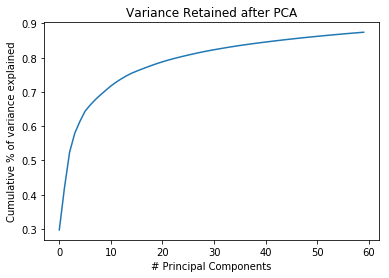

In [17]:
df = pd.DataFrame(pca.explained_variance_ratio_, columns=['Explained Variance'])
df['cumulative_variance'] = df['Explained Variance'].cumsum()
df = df.reset_index()

fig = plt.figure()
ax = plt.axes()
ax.plot(df['cumulative_variance'])
ax.set_xlabel('# Principal Components')
ax.set_ylabel('Cumulative % of variance explained')
ax.set_title('Variance Retained after PCA');

In [18]:
print('shape of train', train_components.shape)
print('shape of dev', dev_components.shape)

shape of train (5286, 60)
shape of dev (1763, 60)


### Viewing PCA Images

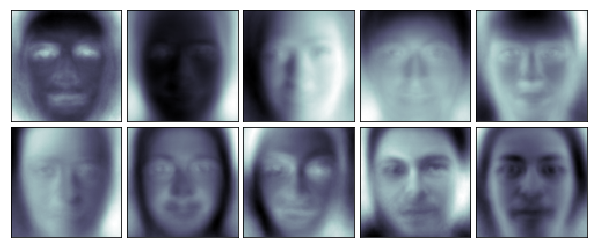

In [19]:
# View first 10 principal components
#Setup a figure 8 inches by 8 inches 
fig = plt.figure(figsize=(8,8)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
nPixels = 96
# plot the faces, each image is 87 by 87 pixels 
for i in range(10): 
  ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[]) 
  ax.imshow(np.reshape(pca.components_[i,:], (nPixels,nPixels)), 
            cmap=plt.cm.bone, interpolation='nearest')

## Model

### Baseline Model: Median of all images

In [20]:
# Create model output and score on dev set (RMSE)
base_model = train.drop(columns='Image').median()

In [21]:
# now see how far off this base model was in mouth_left_corner_x (mse)
# could use full_feature_list

# mouth_features

base_acc = []
for feature in full_feature_list:
  pred_val = base_model[feature]
  nTimes_repeat = len(dev[feature])
  rmse = math.sqrt(metrics.mean_squared_error(dev[feature], 
                                              np.repeat(pred_val, nTimes_repeat)))
  base_acc.append(("Base (Avg Position)",feature, rmse))
  print('Feature: {}, rmse={}'.format(feature, rmse))

Feature: left_eye_center_x, rmse=3.3222642894626473
Feature: left_eye_center_y, rmse=3.0847171795992905
Feature: right_eye_center_x, rmse=3.096788211371273
Feature: right_eye_center_y, rmse=3.014278698589726
Feature: left_eye_inner_corner_x, rmse=2.0442826805085748
Feature: left_eye_inner_corner_y, rmse=2.318196123694883
Feature: left_eye_outer_corner_x, rmse=2.7331599581744697
Feature: left_eye_outer_corner_y, rmse=2.793481793774944
Feature: right_eye_inner_corner_x, rmse=3.043681819873754
Feature: right_eye_inner_corner_y, rmse=2.4259399626134033
Feature: right_eye_outer_corner_x, rmse=3.8415702312502846
Feature: right_eye_outer_corner_y, rmse=3.015803943226453
Feature: left_eyebrow_inner_end_x, rmse=3.1527140023940583
Feature: left_eyebrow_inner_end_y, rmse=3.238215593652716
Feature: left_eyebrow_outer_end_x, rmse=3.5988191238139797
Feature: left_eyebrow_outer_end_y, rmse=3.6659370908172098
Feature: right_eyebrow_inner_end_x, rmse=3.668941558171675
Feature: right_eyebrow_inner_end_y

In [22]:
base_acc

[('Base (Avg Position)', 'left_eye_center_x', 3.3222642894626473),
 ('Base (Avg Position)', 'left_eye_center_y', 3.0847171795992905),
 ('Base (Avg Position)', 'right_eye_center_x', 3.096788211371273),
 ('Base (Avg Position)', 'right_eye_center_y', 3.014278698589726),
 ('Base (Avg Position)', 'left_eye_inner_corner_x', 2.0442826805085748),
 ('Base (Avg Position)', 'left_eye_inner_corner_y', 2.318196123694883),
 ('Base (Avg Position)', 'left_eye_outer_corner_x', 2.7331599581744697),
 ('Base (Avg Position)', 'left_eye_outer_corner_y', 2.793481793774944),
 ('Base (Avg Position)', 'right_eye_inner_corner_x', 3.043681819873754),
 ('Base (Avg Position)', 'right_eye_inner_corner_y', 2.4259399626134033),
 ('Base (Avg Position)', 'right_eye_outer_corner_x', 3.8415702312502846),
 ('Base (Avg Position)', 'right_eye_outer_corner_y', 3.015803943226453),
 ('Base (Avg Position)', 'left_eyebrow_inner_end_x', 3.1527140023940583),
 ('Base (Avg Position)', 'left_eyebrow_inner_end_y', 3.238215593652716),
 

### Function to find accuracy of models

In [23]:
def find_accuracy(model, feature_list, model_name='generic_name'):
    ''' assumes the following exist:
    train_components, 
    dev_componenets, 
    train[features] 
    dev[features]
    '''
    acc_scores = []
  
    for feature in feature_list:
        # fit model on train data with appropriate labels
        fitted_model = model.fit(train_components, train[feature])
        model_pred = fitted_model.predict(dev_components)
        rmse = math.sqrt(metrics.mean_squared_error(dev[feature], model_pred))
        acc_scores.append((model_name, feature, rmse))
    #     print('Feature: {}, rmse={}'.format(feature, rmse))

        return acc_scores

### Run Models

In [24]:
ridge_model_acc = find_accuracy(Ridge(), mouth_features,  model_name='Ridge')
SGD_model_acc = find_accuracy(SGDRegressor(penalty='l1'), mouth_features,  
                              model_name='SGD')

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


### Automl

In [25]:
# TODO - DON'T MAKE THIS PANDAS DF -- DO IT ALL IN NUMPY
# for feature in full_feature_list:
feature = 'mouth_center_top_lip_y'
temp_pre_h2o_df_train= pd.concat([train[feature].reset_index()\
                    .drop(columns='index'), 
                    pd.DataFrame(train_components)], axis=1)
temp_pre_h2o_df_train.to_csv('train_outfile.csv',index=False)

# do the same for dev
temp_pre_h2o_df_dev= pd.concat([dev[feature].reset_index()\
                    .drop(columns='index'), 
                    pd.DataFrame(dev_components)], axis=1)
temp_pre_h2o_df_dev.to_csv('dev_outfile.csv',index=False)

h2o.init()
h2o_train = h2o.import_file(path='train_outfile.csv')
h2o_train = h2o_train.drop([0],axis=0)
h2o_dev = h2o.import_file(path='dev_outfile.csv')
h2o_dev = h2o_dev.drop([0],axis=0)

aml = H2OAutoML(max_runtime_secs = 200)
y = "C1"
x = ["C"+str(n) for n in range(2,62)]

aml.train(x = x, y = y, training_frame=h2o_train, validation_frame=h2o_dev)

lb = aml.leaderboard
# lb.head()
lb.head(rows=lb.nrows)

# save leader
h2o.save_model(aml.leader, path = "./{}".format(feature))

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...


CalledProcessError: Command '['/usr/bin/java', '-version']' returned non-zero exit status 1.

In [ ]:
h2o.init()